# Comparison of Full Grid Stereo with Window-based and Scanline Approaches

## Team members and contributions

- Soyeon Shin:

- Umer Amjad:

## Code Libraries
(acknowledge all external code libraries "essential" for your project. You should explain the importance of each such library for your project. If these libraries are not installed with the default anaconda package, provide installation instructions/links or include the necessary files in extlibs subdirectory.)

## Abstract
TODO: two-three paragraph abstract outlining the high-level goal and discussing well-motivated methodology of the project

First, we have pasted the solutions for window based stereo and scanline stereo from A3 to compare
....

then we do graph cuts stereo 
...

extensions

## Window-based Stereo

Description TODO

5 14


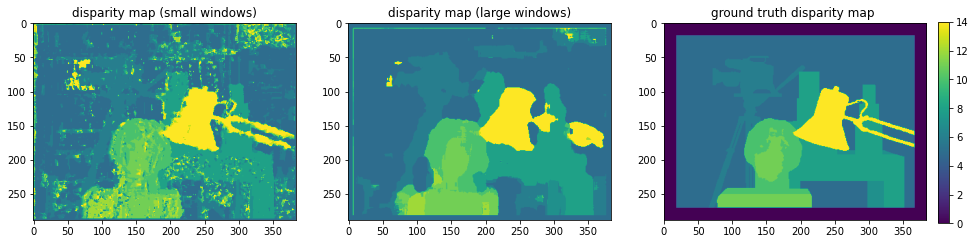

In [5]:
%matplotlib inline
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import matplotlib.image as image
from matplotlib.colors import LogNorm
from skimage import img_as_ubyte
from skimage.color import rgb2grey

INFTY = np.inf
def SD_array(imageL, imageR, d_minimum, d_maximum):
    # initialization of the array of "squared differences" for different shifts
    SD = np.zeros((1+d_maximum-d_minimum,np.shape(imageL)[0],np.shape(imageL)[1]))
    imlf = imageL
    imrf = imageR
    
    for i, d in enumerate(range(d_minimum, d_maximum+1)):
        shiftr = np.roll(imrf, d, axis = 1)
        SD[i] = np.sum(np.square(imlf - shiftr), axis = 2)

    return SD

def integral_image(img):
    integral = np.zeros((np.shape(img)[0],np.shape(img)[1]))
    for r, row in enumerate(img):
        row_sums = np.cumsum(row)
        integral[r] = row_sums
        if r > 0:
            integral[r] += integral[r-1]
    return integral

def windSum(img, window_width):
    integral = integral_image(img)
    forward_half = window_width // 2
    backward_half = window_width - forward_half

    br = np.roll(integral, (-forward_half, -forward_half), axis = (0, 1)) # bottom right
    bl = np.roll(integral, (-forward_half, backward_half), axis = (0, 1)) # bottom left
    tr = np.roll(integral, (backward_half, -forward_half), axis = (0, 1)) # top right
    tl = np.roll(integral, (backward_half, backward_half), axis = (0, 1)) # top left
    
    result =  br - bl - tr + tl
    if backward_half -1 > 0:
        result[:backward_half-1, :] = INFTY
        result[:, :backward_half-1] = INFTY
    if forward_half > 0:
        result[-forward_half:, :] = INFTY
        result[:, -forward_half:] = INFTY
    return result

def SSDtoDmap(SSD_array, d_minimum, d_maximum):
    return d_minimum + np.argmin(SSD_array, axis=0)

def Dmap_Windows(imageL, imageR, d_minimum, d_maximum, window_width):
    SD = SD_array(imageL, imageR, d_minimum, d_maximum)
    SSD = np.zeros(np.shape(SD))
    for d in range(1 + d_maximum - d_minimum):
        SSD[d] = windSum(SD[d], window_width)
    dMap = SSDtoDmap(SSD, d_minimum, d_maximum)
    return dMap


# images/tsukuba subdirectory contains (a subset of) "Tsukuba" stereo images that are probably 
# the oldest stereo data with dense ground-truth produced at the University of Tsukuba in 2001. 
# The full Tsukuba dataset and many other stereo images with ground-truth disparity maps can be
# downloaded from well-known Middlebury repository  http://vision.middlebury.edu/stereo/
im_left = image.imread("images/stereo_pairs/tsukuba/scene1.row3.col3.ppm")
im_gt = image.imread("images/stereo_pairs/tsukuba/truedisp.row3.col3.pgm")
im_right = image.imread("images/stereo_pairs/tsukuba/scene1.row3.col4.ppm")
im_right2 = image.imread("images/stereo_pairs/tsukuba/scene1.row3.col5.ppm")


d_min = np.amin(im_gt[np.nonzero(im_gt)]) // 16 
d_max = np.amax(im_gt) //16 
print(d_min, d_max)


dispMap_small = Dmap_Windows(im_left, im_right, d_min, d_max, 4)
dispMap_large = Dmap_Windows(im_left, im_right, d_min, d_max, 15)

fig = plt.figure(figsize = (16, 7))
plt.subplot(131)
plt.title("disparity map (small windows)")
plt.imshow(dispMap_small, vmin = 0, vmax = d_max)
plt.subplot(132)
plt.title("disparity map (large windows)")
plt.imshow(dispMap_large, vmin = 0, vmax = d_max)
plt.subplot(133) 
plt.title("ground truth disparity map ")
plt.imshow(im_gt/16, vmin = 0, vmax = d_max)
plt.colorbar(cax=plt.axes([0.91, 0.3, 0.01, 0.4]))


In [ ]:


im_left = image.imread("images/Bicycle1-imperfect/im0.png")
im_right = image.imread("images/Bicycle1-imperfect/im1.png")
# im_gt = image.imread("images/Bicycle1-imperfect/disp0.pfm")
d_min = np.amin(im_gt[im_gt != 0]) / 16
d_max = np.amax(im_gt[im_gt != 0]) / 16
dispMap_small = Dmap_Windows(im_left, im_right, d_min, d_max, 4)
dispMap_large = Dmap_Windows(im_left, im_right, d_min, d_max, 15)
fig = plt.figure(figsize = (16, 7))
plt.subplot(131)
plt.title("disparity map (small windows)")
plt.imshow(dispMap_small, vmin = 0, vmax = d_max)
plt.subplot(132)
plt.title("disparity map (large windows)")
plt.imshow(dispMap_large, vmin = 0, vmax = d_max)
plt.subplot(133)
plt.title("ground truth disparity map ")
plt.imshow(im_gt/16, vmin = 0, vmax = d_max)
plt.colorbar(cax=plt.axes([0.91, 0.3, 0.01, 0.4]))

## Scan-line Stereo

Basic scanline, where the photo-consistency term of the loss function (objective function) is implemented $\text{SD_array}$ 

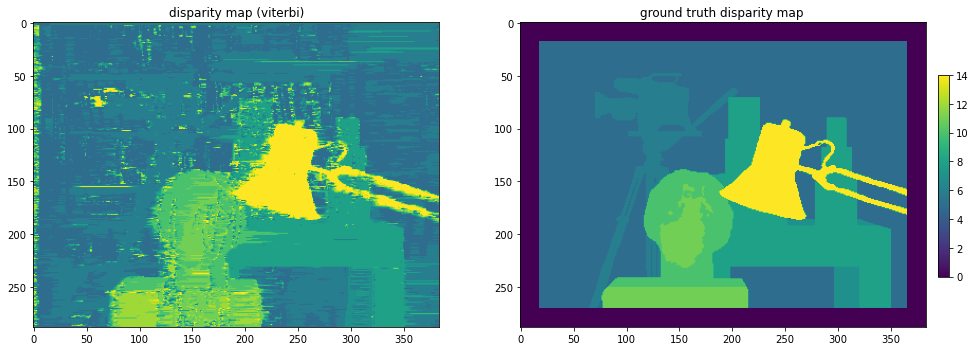

In [7]:
# SD gives the array of Dp(d) for pixel p and disparity d
# So to get edge costs E(p, p+1) = Dp + V(p, p+1)
# So we can create an array of edge costs:

w = 20

disps = np.array(range(d_min, d_max + 1))

# matrix of regularization weights for disparities:
disp_curr = np.transpose(np.tile(disps, (len(disps), 1)))
disp_prev = np.tile(disps, (len(disps), 1))
reg_weight = w * np.absolute(disp_curr - disp_prev)

# returns E, Prev
def Viterbi(r, scanline, disps, photo_const, reg_weight):
    E = np.zeros((len(scanline), len(disps))) # row i is E_bar_i()
    Prev = np.zeros((len(scanline), len(disps)), dtype = int) # keep track of minimum chosen 
    for c, cell in enumerate(scanline):
        if c == 0:
            continue
        prev_E = np.tile(E[c-1], (len(disps), 1))
        photo_consts = np.tile(photo_const[:, r , c-1], (len(disps), 1))
        loss = reg_weight + prev_E + photo_consts
        Prev[c] = np.argmin(loss, axis = 1)
        E[c] = loss[np.arange(np.shape(loss)[0]), Prev[c]]
    return E, Prev


def dispMapViterbi(img, disps, photo_const, reg_weight):
    dispMap_viterbi = np.zeros((np.shape(img)[0], np.shape(im_right)[1]))
    for r, scanline in enumerate(img):
    
        E, Prev = Viterbi(r, scanline, disps, photo_const, reg_weight)
        # look at index of min of last row of E
        index =  np.argmin(E[-1])
        # get back all previous disparaties based on that minimum
        for c in reversed(range(len(scanline))):
            dispMap_viterbi[r][c] = disps[index]
            index = Prev[c][index]
    return dispMap_viterbi

SD = SD_array(im_left, im_right, d_min, d_max)    
dispMap_viterbi = dispMapViterbi(im_right, disps, SD, reg_weight)

fig = plt.figure(figsize = (16, 7))
plt.subplot(121)
plt.title("disparity map (viterbi)")
plt.imshow(dispMap_viterbi, vmin = 0, vmax = d_max)
plt.subplot(122) 
plt.title("ground truth disparity map ")
plt.imshow(im_gt/16, vmin = 0, vmax = d_max)
plt.colorbar(cax=plt.axes([0.91, 0.3, 0.01, 0.4]))

Test the case where the photoconsistency term $D_p(d)$ is computed by averaging SD in some small window of size $h$. That is, for each disparity $d$ you should replace 2D array $\text{SD_array}(d)$ in Problem 7(a) by $$\text{SD_array}(d)   \;\;\;\;\;\longleftarrow\;\;\;\;  windSum(SD(d),h).$$ Compare the results for different window sizes $h\in\{1,3,5\}$. Feel free to fine tune regularization parameter $w$ for each case trying to obtain the better results. 

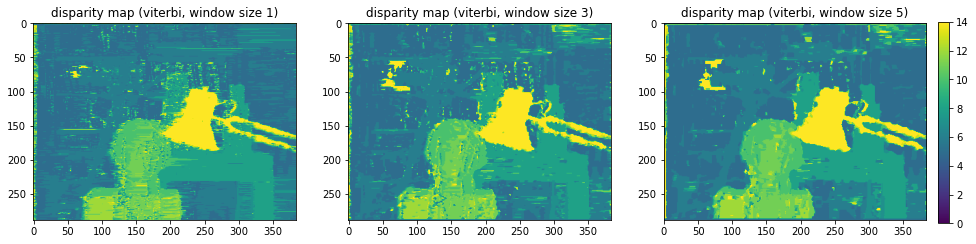

In [8]:
w = 20

reg_weight = w * np.absolute(disp_curr - disp_prev)

SD_1 = np.array([windSum(s, 1) for s in SD])
SD_3 = np.array([windSum(s, 3) for s in SD])
SD_5 = np.array([windSum(s, 5) for s in SD])

SD_3[SD_3 == INFTY] = 0
SD_5[SD_5 == INFTY] = 0

viterbi_1 = dispMapViterbi(im_right, disps, SD_1, reg_weight)
viterbi_3 = dispMapViterbi(im_right, disps, SD_3, reg_weight)
viterbi_5 = dispMapViterbi(im_right, disps, SD_5, reg_weight)

fig = plt.figure(figsize = (16, 7))
plt.subplot(131)
plt.title("disparity map (viterbi, window size 1)")
plt.imshow(viterbi_1, vmin = 0, vmax = d_max)
plt.subplot(132) 
plt.title("disparity map (viterbi, window size 3)")
plt.imshow(viterbi_3, vmin = 0, vmax = d_max)
plt.subplot(133) 
plt.title("disparity map (viterbi, window size 5)")
plt.imshow(viterbi_5, vmin = 0, vmax = d_max)
plt.colorbar(cax=plt.axes([0.91, 0.3, 0.01, 0.4]))

## Full Grid Stereo

## Conclusion
two-three paragraphs summarizing the conclusions of your project